In [1]:
import os
import pickle


import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
from tqdm.auto import tqdm

import multitask.dataset as dataset
from multitask.models.task_switching import get_task_model
import multitask.models.task_switching.hooks as hooks
from multitask.utils.training import get_device
from multitask.utils.argparse import check_runs

In [2]:
plt.style.use('../style/plots.mplstyle')
palette = ['#c0d9ffff', '#bfc1ffff', '#e3bfffff', '#ffbfe6ff', '#ffbfc4ff']

In [3]:
path_data = os.path.join('..', '..', 'data')
path_model_task_switching = os.path.join('..', '..', 'results', 'task_switching')
path_figure = os.path.join('svg', 'figureS30_sparsity_2_tasks_letters.svg')

In [4]:
num_runs = 10
initial_seed = 1234
max_seed = 10e5
num_epochs = 50
num_hidden = 10 * [100]
batch_size = 100
num_train = 41080
num_test = 8216
tasks_names = ['vowel', 'position']
idxs_contexts = list(range(len(num_hidden)))

In [5]:
parameters = {
    'num_runs': num_runs,
    'initial_seed': initial_seed,
    'max_seed': max_seed,
    'num_epochs': num_epochs,
    'num_hidden': num_hidden,
    'batch_size': batch_size,
    'num_train': num_train,
    'num_test': num_test,
    'tasks': tasks_names,
    'idxs_contexts': idxs_contexts
}

data_folder = check_runs(path_model_task_switching, parameters)

Found simulation in ../../results/task_switching with the same parameters (2024-01-12_18-56-09)


In [6]:
pickle_data = os.path.join(data_folder, 'data.pickle')
with open(pickle_data, 'rb') as handle:
    results_task_switching = pickle.load(handle)

In [7]:
seeds = sorted(list(results_task_switching.keys()))
num_seeds = len(seeds)
num_tasks = len(tasks_names)

print(seeds)
print(tasks_names)

[165158, 220532, 318129, 451283, 486191, 514041, 818831, 869016, 908341, 978124]
['vowel', 'position']


In [8]:
tasks_datasets = dataset.get_tasks_dict(tasks_names, root=path_data)

task_switching_tasks = {}
num_tasks = len(tasks_names)

for i_context, task_name in enumerate(tasks_names):
    task_switching_tasks[task_name] = {}
    task_switching_tasks[task_name]['data'] = tasks_datasets[task_name]
    task_switching_tasks[task_name]['activations'] = num_tasks * [0]
    task_switching_tasks[task_name]['activations'][i_context] = 1

for key, value in task_switching_tasks.items():
    print(f'{key}: {value["activations"]}')

vowel: [1, 0]
position: [0, 1]


In [9]:
device = get_device()
criterion = nn.CrossEntropyLoss()
num_layers = len(num_hidden)

num_clusters = 3
num_letters = 26

avg_activations_units = np.zeros((num_runs, num_hidden[0], num_tasks * num_letters, num_layers))

for i_seed, seed in tqdm(enumerate(seeds), total=num_runs):
    state_dict = results_task_switching[seed]['model']
    model = get_task_model(task_switching_tasks,
                           num_hidden,
                           idxs_contexts,
                           device)
    model.load_state_dict(state_dict)
    
    indices = results_task_switching[seed]['indices']

    test_sampler = dataset.SequentialSampler(indices['test'])
    _, test_dataloaders = dataset.create_dict_dataloaders(task_switching_tasks,
                                                          indices,
                                                          batch_size=batch_size)
    tasks_testloader = dataset.SequentialTaskDataloader(test_dataloaders)

    letters = test_dataloaders[tasks_names[0]].dataset.letters.numpy()
    letters = letters[indices['test']]

    _, activations = hooks.get_layer_activations(model,
                                                tasks_testloader,
                                                criterion,
                                                device=device,
                                                disable=True)

    for i_layer in range(num_layers):
        name_layer = f'layer{i_layer+1}'
        for i_task, task_name in enumerate(tasks_names):
            current_activations = activations[task_name][name_layer]
            for i_unit in range(num_hidden[0]):
                activation_unit = current_activations[:, i_unit]
                for i_digit in range(num_letters):
                    avg_activations_units[i_seed, i_unit, i_task * num_letters + i_digit, i_layer] = np.mean(activation_unit[letters == i_digit])

Running on CPU.


  0%|          | 0/10 [00:00<?, ?it/s]

In [10]:
sparse_units = np.zeros((num_seeds, num_layers))
for i_seed in range(num_seeds):
    activations_seed = avg_activations_units[i_seed]
    sparse_units[i_seed] = (activations_seed.sum(axis=1) == 0).mean(axis=0)
    

In [11]:
mean_sparse_units = sparse_units.mean(axis=0)
std_sparse_units = sparse_units.std(axis=0)

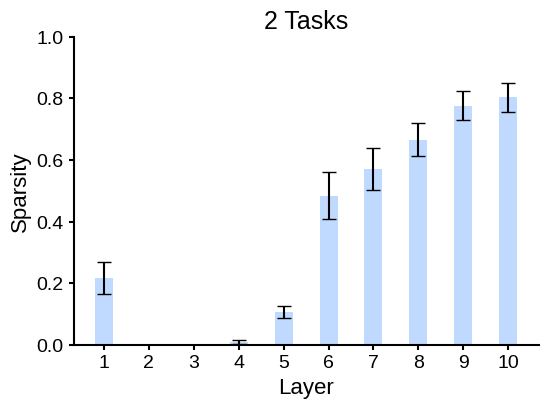

In [12]:
layers = list(range(1, 11))

fig = plt.figure(figsize=(6, 4))

plt.bar(layers, mean_sparse_units, width=0.4, color=palette[0])
plt.errorbar(layers, mean_sparse_units, std_sparse_units, color='k', linestyle='', capsize=5)

plt.xlabel('Layer')
plt.ylabel('Sparsity')
plt.title('2 Tasks')
plt.xticks(layers)

plt.ylim(0, 1)

fig.savefig(path_figure)

plt.show()